# Assignment5 - Question 1  (Alejandro Akifarry - 301-195-788)
---

In [ ]:
# newer numpy versions than this gave me errors
!pip install numpy==1.26.0

## Imports

In [58]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from scikeras.wrappers import KerasRegressor

---

## 1. Use the training set, validation set, and test set from Assignment 3 (Hierarchical Clustering) for this Assignment.

In [59]:
olivetti_faces = fetch_olivetti_faces()
X = olivetti_faces.data
y = olivetti_faces.target
images = olivetti_faces.images # 64x64 version of .data
print(X.shape)
print(y.shape)

(400, 4096)
(400,)


In [60]:
# First split into train + validation (90%) and test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y)

# Now split the train + validation set (90%) into train (80%) and validation (10%)
# 10/90 = 0.1111
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, random_state=42, stratify=y_train_val)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(320, 4096)
(40, 4096)
(40, 4096)


---

## 2. Use PCA preserving 99% of the variance to reduce the dataset’s dimensionality as in Assignment 4 (Gaussian Mixture Models) and use it to train the autoencoder

In [65]:
pca = PCA(n_components=0.99)

X_train_reduced = pca.fit_transform(X_train)

print(X_train_reduced.shape)
print(y_train.shape)

(320, 222)
(320,)


In [66]:
X_val_reduced = pca.transform(X_val)
X_test_reduced = pca.transform(X_test)

print(X_val_reduced.shape)
print(X_test_reduced.shape)

(40, 222)
(40, 222)


In [75]:
print(np.max(X_train_reduced))
print(np.min(X_train_reduced))

10.986128
-11.621853


---

## 3. Define an autoencoder with the given architecture.

In [67]:
# we'll use 222 for input shape because of PCA
def build_autoencoder(latent_features=2, 
                      learning_rate=0.01,
                      regularizer_param=0.01, 
                      hidden_units=32):
    model = Sequential()
    
    input_shape = X_train_reduced.shape[1] # based on PCA on previous step
    
    model.add(Input(shape=(input_shape,)))
    
    # Top Hidden layer 1
    model.add(Dense(hidden_units, activation='linear', 
                  kernel_regularizer=regularizers.l2(regularizer_param)))
    
    # Central layer 2
    model.add(Dense(latent_features, activation='linear',
                  kernel_regularizer=regularizers.l2(regularizer_param)))
    
    # Top Hidden layer 3
    model.add(Dense(hidden_units, activation='linear',
                  kernel_regularizer=regularizers.l2(regularizer_param)))
    
    # Output
    model.add(Dense(units=input_shape, activation='linear'))
    
    # Compile
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

### a. Use k-fold cross validation to fine tune the model’s learning rate and hyperparameter of the regularizer.  Due to the long training requirements, for the number of hidden units, try two or three different values for each hidden layer.

In [68]:
model = KerasRegressor(model=build_autoencoder, epochs=10, verbose=0)
param_grid = {
    'model__latent_features': [75, 100],
    'model__learning_rate': [0.0001, 0.001],
    'model__regularizer_param': [0.0001, 0.001],
    'model__hidden_units': [125, 150]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=3, error_score='raise')

grid_result = grid.fit(X_train_reduced, X_train_reduced)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END model__hidden_units=125, model__latent_features=75, model__learning_rate=0.0001, model__regularizer_param=0.0001;, score=-3.061 total time=   0.9s
[CV 2/5] END model__hidden_units=125, model__latent_features=75, model__learning_rate=0.0001, model__regularizer_param=0.0001;, score=-3.390 total time=   0.9s
[CV 3/5] END model__hidden_units=125, model__latent_features=75, model__learning_rate=0.0001, model__regularizer_param=0.0001;, score=-2.929 total time=   0.9s
[CV 4/5] END model__hidden_units=125, model__latent_features=75, model__learning_rate=0.0001, model__regularizer_param=0.0001;, score=-3.478 total time=   0.9s
[CV 5/5] END model__hidden_units=125, model__latent_features=75, model__learning_rate=0.0001, model__regularizer_param=0.0001;, score=-3.660 total time=   0.9s
[CV 1/5] END model__hidden_units=125, model__latent_features=75, model__learning_rate=0.0001, model__regularizer_param=0.001;, score=-3.007

In [70]:
print(f"Best Score: {grid_result.best_score_:.4f}")
print(f"Best Hyperparameters: {grid_result.best_params_}\n")

Best Score: -0.2616
Best Hyperparameters: {'model__hidden_units': 150, 'model__latent_features': 75, 'model__learning_rate': 0.001, 'model__regularizer_param': 0.001}



### b. Discuss the rationale with respect to the activation functions and loss function used in your model.

For all the hidden layers and output layer, I used the linear activation function for all of them. This is because after applying PCA, the dataset is no longer normalized between 0 and 1. It became around -11 to 10. Because of this, I used linear to not lose information/pattern. For example, if I were to use "relu", I will lose the negative values, and if I use "tanh", my values will be squished too much.

As for the loss function, I used MSE (Mean Squared Error). This is because both our inputs and outputs are the same dimensions, which means that we can calculate how different they are from each other using MSE. In addition, since the errors are squared, it penalizes the model more when making large errors, which is good because even small changes can impact the quality of the reconstructed image.

---

## 4. Run the best model with the test set and display the original image and the reconstructed image.

In [71]:
best_model = grid_result.best_estimator_

X_test_reduced = pca.transform(X_test)

reconstructed_images = best_model.predict(X_test_reduced)

reconstructed_images_full = pca.inverse_transform(reconstructed_images)

In [72]:
reconstructed_images.shape

(40, 222)

In [73]:
reconstructed_images_full.shape

(40, 4096)

### All linear activation functions:

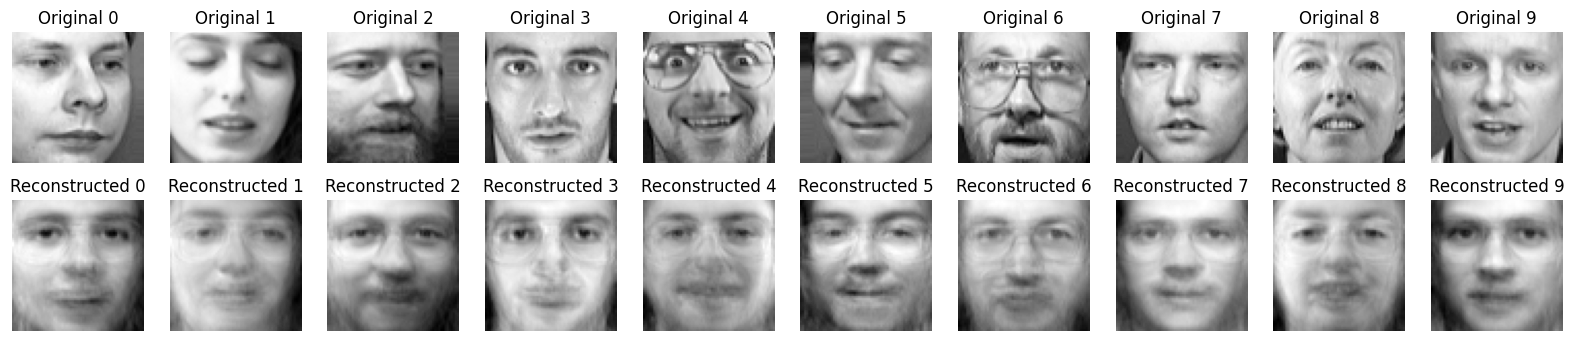

In [74]:
# Choose how many images to display
n = 10  # Number of images to display

# Reshape the images if needed, for example, if the data is flattened
image_shape = (64, 64)  # For Olivetti faces dataset, the image size is 64x64

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(image_shape), cmap='gray')
    plt.title(f"Original {i}")
    plt.axis('off')

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images_full[i].reshape(image_shape), cmap='gray')
    plt.title(f"Reconstructed {i}")
    plt.axis('off')

plt.show()

---